**Practica 4: Homología persistente (Para esta no hay ejemplos en moodle)**

Definir un método en la clase complejos simpliciales que calcule la matriz borde generalizado de un complejo simplicial filtrado.


In [11]:
# La matriz de borde generalizado es una matriz cuyas filas y columnas son todos los símplices de todas las dimensiones 
# ordenados según el orden total de emparejamiento nacimiento-muerte (ver slides)
# que verifcan que cada elemento es 1 si σi es una cara de codimensión 1 de σj, y 0 en caso contrario.

# Añadimos la clase ComplejoSimplicial de la Práctica 1 e implementamos al final el método matriz_borde_generalizado.

from itertools import chain, combinations

class ComplejoSimplicial:

    def __init__(self, sim_maximales):
        """
        Inicializa el complejo simplicial tomando como argumento lo que serían los maximales del poset
        """
        self.simplices = dict()
        self.simplices_ordenados = [] # Nuevo atributo para guardar los simplices ordenados por flotante y dimensión
        sim_derivados = self.derivar_simplices(sim_maximales)
        for sim in sim_derivados:
            if isinstance(sim, int):
                dim = 0
            else:    
                dim = len(sim)-1
            if dim not in self.simplices:
                self.simplices[dim] = set()
            self.simplices[dim].add(sim)

    def derivar_simplices(self, simplices_maximales):
        """
        Genera el complejo simplicial tomando todos los subconjuntos de los símplices maximales.
        
        Args:
        simplices_maximales (list of tuples): Lista de símplices maximales.
        
        Returns:
        set: El conjunto de todos los símplices en el complejo simplicial.
        """
        complejo = set()
        for simplice in simplices_maximales:
            complejo.update(self.potencia(simplice))
        return complejo
    
    def potencia(self, simplice):
        """
        Genera todos los subconjuntos(caras) de un simplice (incluido el propio simplice).
        
        Args:
        simplice (tuple): Un simplice representado como una tupla de vértices.
        
        Returns:
        set: Conjunto de todos los subconjuntos del simplice.
        """
        return set(chain.from_iterable(combinations(simplice, r) for r in range(len(simplice) + 1)))
    
    def insert(self, simplices, value):
        """
        Añade nuevos símplices al complejo simplicial con un valor flotante asociado.
        
        Args:
        simplices (list of tuples): Lista de símplices representados como tuplas de vértices.
        value (float): Valor flotante a asociar con cada simplice.
        """
        for simplice in simplices:
            nuevos_simplices = self.potencia(simplice)
            for sim in nuevos_simplices:
                if isinstance(sim, int):
                    dim = 0
                else:
                    dim = len(sim) - 1
                if dim not in self.simplices:
                    self.simplices[dim] = set()
                self.simplices[dim].add((sim, value))
                # Añadir a la lista de simplices ordenados
                self.simplices_ordenados.append((sim, dim, value))

        # Ordenar los símplices primero por valor flotante, luego por dimensión
        self.simplices_ordenados.sort(key=lambda x: (x[2], x[1]))

    def filtracion(self, umbral):
        """
        Devuelve un nuevo complejo simplicial formado por todos los símplices cuyo valor flotante asociado 
        sea menor o igual que el flotante dado.
        
        Args:
        umbral (float): El valor máximo del flotante permitido en la filtración.
        
        Returns:
        ComplejoSimplicial: Un nuevo complejo simplicial con simplices filtrados.
        """
        simplices_filtrados = []
        for simplice, dim, value in self.simplices_ordenados:
            if value <= umbral:
                simplices_filtrados.append(simplice)
        
        # Crear un nuevo complejo simplicial con los símplices filtrados
        return ComplejoSimplicial(simplices_filtrados)
  
    def dim(self):
        """
        Devuelve la dimension del complejo simplicial, que es el maximo de las dimensiones de los simplices.
        """
        return max(self.simplices.keys())

    
    def caras(self, dim):
        """
        Devuelve una lista con las caras de un complejo simplicial para una dimension dada
        """
        caras = []
        for cara in self.simplices[dim]:
            caras.append(cara)
        return caras

    
    def face_set(self):
        """
        Devuelve todas las caras del complejo simplicial, ignorando los flotantes asociados.
        """
        def extract_simplice(simplice):
            # Si el simplice es una tupla no vacía con un flotante, extrae solo la parte entera
            if isinstance(simplice, tuple) and len(simplice) > 0 and isinstance(simplice[-1], float):
                return simplice[:-1]
            return simplice
    
        caras = set()
        for dim in self.simplices:
            for cara in self.simplices[dim]:
                caras.add(extract_simplice(cara))

        # Eliminar el conjunto vacío
        return set(cara for cara in caras if cara != ())

    def estrella(self, simplice):
        """
        Devuelve la estrella de un simplice dado
        Se buscan las caras que contienen completamente a dicho simplice
        """
        simplice = set(simplice)  # Convertimos el simplice en un conjunto(set), para poder hacer intersecciones
        # Caras cuya intersección con el simplice es el simplice
        return set(cara for cara in self.face_set() if simplice.intersection(cara) == simplice)
    
    
    def estrella_cerrada(self, simplex):
        """
        Devuelve la estrella cerrada de un simplice dado.
        La estrella cerrada es el menor subcomplejo simplicial que contiene a la estrella de un simplice dado.
        """
        # Obtenemos la estrella del simplex dado
        estrella = self.estrella(simplex)
        # Inicializamos la estrella cerrada como un conjunto vacío
        estrella_cerrada = set()
        cubiertos = set()  # Para rastrear qué simplices de la estrella están cubiertos
        
        # Recorremos todos los símplices de menor a mayor dimensión
        for dim in sorted(self.simplices.keys()):
            for cara in self.simplices[dim]:
                cara_set = set(cara)
                
                # Verificamos si la cara cubre algunos simplices de la estrella
                if any(set(s).issubset(cara_set) for s in estrella):
                    estrella_cerrada.add(cara)
                    # Actualizamos los simplices de la estrella que están cubiertos
                    cubiertos.update(s for s in estrella if set(s).issubset(cara_set))
                
                # Si ya hemos cubierto todos los simplices de la estrella, podemos detenernos
                if cubiertos == estrella:
                    break
        
        return estrella_cerrada
  
    
    def link(self, simplice):
        """
        Devuelve el link del simplice dado
        El link de un simplice es el conjunto de simplices de la estrella cerrada con interseccion vacia con el simplice.
        """
        # Obtenemos la estrella cerrada del simplice.
        estrella_cer = self.estrella_cerrada(simplice)
        # Convertimos en complejo simplicial, para poder obtener todas sus  con face_set()
        ec = ComplejoSimplicial(estrella_cer)
        # Nos quedamos con los simplices de la estrella cerrada que no intersecan con el simplice del que queremos obtener el link
        return set(cara for cara in ec.face_set() if not set(simplice).intersection(cara))

    
    def print_caras(self):
        """
        Permite printear el complejo simplicial por dimensiones
        """
        dim = self.dim()
        for i in range(0,dim+1):
            print("Caras de dim: ", i)
            d_caras = self.caras(i)
            for cara in d_caras:
                print(cara)
    
    
    def carac_euler(self):
        """
        Calcula la característica de Euler del complejo simplicial.
        Consiste en la suma alternante de los números de simplices de cada dimensión.
        """
        """ dim = self.dim()
        res = 0
        for i in range(0, dim+1):
            if i % 2 == 0:
                res += len(self.simplices[dim])
            else:
                res -= len(self.simplices[dim])
        return res """
        # Forma más eficiente
        return sum((-1)**k * len(self.simplices[k]) for k in range(self.dim()+1))
    

    def num_componentes_conexas(self):
        """
        Devuelve el número de componentes conexas del complejo simplicial
        """
        n = 0
        vertices = list(self.simplices[0])
        aristas = self.simplices[1]

        v_conexos = []
        v_inconexos = []
        v0 = vertices[0]

        while True:
            #print('hola')
            for v in vertices[:]:
                print(f"v0: {v0}, v: {v}, existe_camino: {self.existe_camino(v0[0], v[0], aristas)}")
                if self.existe_camino(v0[0], v[0], aristas):
                    v_conexos.append(v)
                    vertices.remove(v)
                else:
                    v_inconexos.append(v)
            
            n += 1
            if len(vertices) == 0:
                return n
            v0 = vertices[0]
            v_conexos = []
            v_inconexos = []


    def existe_camino(self, v, u, aristas):
        #print(aristas)
        # Crear el grafo como un diccionario de adyacencia
        grafo = dict()
        
        # Construir el diccionario de adyacencia a partir de las aristas
        for v1, v2 in aristas:
            if v1 not in grafo.keys():
                grafo[v1] = []
            if v2 not in grafo:
                grafo[v2] = []
            grafo[v1].append(v2)
            grafo[v2].append(v1)  # Como es un grafo no dirigido, añadir ambas conexiones

        # Función recursiva para la búsqueda en profundidad (DFS)
        def bep(vertice, visitados):
            if vertice == u:
                return True
            visitados.append(vertice)  # Marcar el vértice como visitado
            # Recorrer los vecinos
            if vertice in grafo.keys():
                for vecino in grafo[vertice]:  # Obtener vecinos del vértice
                    if vecino not in visitados:  # Solo visitar los no visitados
                        if bep(vecino, visitados):
                            return True
            
            return False
        
        return bep(v, list())
    
    def skeleton(self, k):
        """
        Devuelve el esqueleto de dimensión k del complejo simplicial.
        
        Args:
        k (int): La dimensión máxima de los simplices en el esqueleto.
        
        Returns:
        ComplejoSimplicial: Un nuevo complejo simplicial que es el esqueleto de dimensión k.
        """
        # Recopilar todas las caras de dimensión k o menor
        caras_k_o_menor = set()
        for dim in range(k + 1):
            if dim in self.simplices:
                caras_k_o_menor.update(self.simplices[dim])
        
        # Crear un nuevo complejo simplicial con estas caras
        return ComplejoSimplicial(list(caras_k_o_menor))
    
    def treshold(self, simplice):
        """
        Devuelve el valor mínimo asociado al simplice dado (donde el simplice aparece por primera vez).
        
        Args:
        simplice (tuple): Un simplice representado como una tupla de vértices.
        
        Returns:
        float: El valor flotante mínimo asociado al simplice, o None si no se encuentra.
        """
        min_value = None
        
        for dim in self.simplices:
            for cara in self.simplices[dim]:
                if isinstance(cara, tuple) and set(simplice).issubset(cara[0]):
                    value = cara[1]
                    # Guardamos el valor mínimo
                    if min_value is None or value < min_value:
                        min_value = value
                        
        return min_value

    def matriz_borde_generalizado(self):
        """
        Calcula la matriz de borde generalizada para el complejo simplicial.
        La matriz de borde tiene como filas y columnas los símplices ordenados
        por el valor flotante y dimensión, siguiendo las reglas establecidas.

        Returns:
            numpy.ndarray: Matriz de borde generalizada.
        """
        import numpy as np

        # los símplices están ordenados por valor flotante y dimensión
        simplices = self.simplices_ordenados
        num_simplices = len(simplices)

        # Inicializar matriz nxn con ceros, donde n es el número de símplices.
        matriz_borde = np.zeros((num_simplices, num_simplices), dtype=int)

         # Construir la matriz borde
        for j, (sigma_j, dim_j, _) in enumerate(simplices):
            if dim_j == 0:  # Los vértices no tienen caras propias
                continue
            for i, (sigma_i, dim_i, _) in enumerate(simplices[:j]):  # Restricción: i < j garantiza triangularidad
                if dim_i == dim_j - 1 and set(sigma_i).issubset(sigma_j):
                    # Si sigma_i es una cara de codimensión 1 de sigma_j
                    matriz_borde[i, j] = 1

        return matriz_borde


In [12]:
# Ejemplo de uso. Definimos un complejo simplicial, sacado de la práctica 1
sc = ComplejoSimplicial([])
sc.insert([(0,1)], 1.0)
sc.insert([(1,2), (2,3), (2,4)], 2.0)
sc.insert([(3,4)], 3.0)
sc.insert([(2,3,4)], 4.0)

In [ ]:
# Calculamos e imprimimos la matriz de borde generalizada. Debería ser triangular superior.
matriz_borde = sc.matriz_borde_generalizado()
print(matriz_borde)


[[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 1 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 0 0 0 0 0 0 0 0 1 0 1 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 1 0 0 0 0 0 1 1 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 0 0 0 0 0 0 0 0 1 0 1 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 0 0 0 0 0 0 0 0 1 0 1 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 1 0 0 0 0 1 1 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 

Definir una función que calcule el low de una columna de una matriz.

In [14]:
# Dada una columna j no nula, el low(j) es el índice i de la última fila tal que a[i, j] = 1.

def low(matriz, j):
    """
    Calcula el low de una columna de una matriz.

    Args:
        matriz (numpy.ndarray): La matriz en cuestión.
        j (int): El índice de la columna para la que se calculará low(j).

    Returns:
        int: El mayor índice i para el cual a[i, j] = 1, o None si la columna es nula.
    """
    # Iterar desde la última fila hasta la primera
    for i in range(matriz.shape[0] - 1, -1, -1):
        if matriz[i, j] == 1:
            return i
    return None  # Si la columna es nula


In [16]:
# Ejemplo con la matriz anterior
j = 13
print(f"low({j}) = {low(matriz_borde, j)}")  

low(13) = 11


Definir una función que reduzca por columnas una matriz cuadrada según el algoritmo matricial de cálculo de persistencia.

In [17]:
def reducir_columnas(matriz, calcular_low):
    """
    Reduce una matriz por columnas según el algoritmo:
    - Si low(j) está definido (columna j es no nula), busca j0 < j con low(j0) = low(j).
    - Si se encuentra tal j0, suma la columna j0 a la columna j.

    Args:
        matriz (numpy.ndarray): Matriz a reducir.
        calcular_low (function): Función que calcula el low de una columna dada.

    Returns:
        numpy.ndarray: La matriz reducida.
    """
    # Copiar la matriz para no modificar la original
    matriz_reducida = matriz.copy()
    num_columnas = matriz_reducida.shape[1]

    # Iterar por columnas
    for j in range(num_columnas):
        while True:
            # Calcular low(j)
            low_j = calcular_low(matriz_reducida, j)
            if low_j is None:
                break  # Si la columna es nula, no hay nada que reducir

            # Buscar j0 < j tal que low(j0) = low(j)
            j0 = None
            for k in range(j):
                if calcular_low(matriz_reducida, k) == low_j:
                    j0 = k
                    break

            if j0 is None:
                break  # No hay reducción posible

            # Reducir la columna j sumando la columna j0. Usamos aritmética módulo 2.
            matriz_reducida[:, j] = (matriz_reducida[:, j] + matriz_reducida[:, j0]) % 2

    return matriz_reducida

In [18]:
M_reducida = reducir_columnas(matriz_borde, low)
print(M_reducida)

[[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 1 0 0 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 1 0 0 0 0 0 0 0 0 1 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 1 0 0 0 0 0 1 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 1 0 0 0 0 0 0 0 0 1 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 1 0 0 0 0 0 0 0 0 1 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 1 0 0 0 0 1 1 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 

In [ ]:
# La matriz reducida satisface la propiedad de que no hay dos columnas no nulas con el mismo low.

# Suma de todos los elementos de la matriz
print(f"Suma de todos los elementos de la matriz reducida: {M_reducida.sum()}")
# matriz borde
print(f"Matriz de borde original: {matriz_borde.sum()}")

Suma de todos los elementos de la matriz: 37
Matriz de borde original: 45


Definir una función que tenga como datos de entrada un conjunto finito de puntos en el plano y que calcule los puntos del diagrama de persistencia de la filtración de alfa complejos asociada a dicho conjunto de puntos.

In [1]:
# Recuperamos la clase AlfaComplejo de la práctica 2

import numpy as np
from scipy.spatial import Delaunay

class AlfaComplejo:
    """
    Clase para calcular el Alfa Complejo de un conjunto de puntos en 2D.
    
    Atributos:
    - points: np.array de puntos en 2D.
    - triangulation: Triangulación de Delaunay de los puntos.
    - simplices: Lista de símplices (triángulos, aristas y puntos) de la triangulación.
    - alpha_values: Diccionario que almacena los valores de alfa para cada símplice.
    """
    
    def __init__(self, points):
        """
        Inicializa la clase con un conjunto de puntos y calcula la triangulación de Delaunay.
        
        Parámetros:
        - points: np.array de puntos en 2D.
        """
        self.points = points
        self.triangulation = Delaunay(points) # Delaunay solo devuelve los triángulos
        self.simplices = self.get_all_simplices()
        self.alpha_values = self.calculate_alpha_values()

    def get_all_simplices(self):
        """
        Obtiene todos los símplices (puntos, aristas y triángulos) de la triangulación de Delaunay.
        
        Retorna:
        - Lista de símplices.
        """
        simplices = set()
        # Añadir puntos
        for i in range(len(self.points)):
            simplices.add((i,))
        # Añadir aristas y triángulos
        for simplex in self.triangulation.simplices:
            for i in range(3):
                # Añadir aristas
                simplices.add(tuple(sorted([simplex[i], simplex[(i + 1) % 3]])))
            # Añadir triángulos
            simplices.add(tuple(sorted(simplex)))
        return list(simplices)

    def calculate_alpha_values(self):
        """
        Calcula los valores de alfa para cada símplice en la triangulación de Delaunay.
        Seguimos el algoritmo dado en las diapositivas de la asignatura.
        
        Retorna:
        - alpha_values: Diccionario con los valores de alfa para cada símplice.
        """
        alpha_values = {}
        for simplex in self.simplices:
            vertices = self.points[list(simplex)]
            if len(vertices) == 3:
                # Calcular el circunradio para triángulos
                A = np.linalg.norm(vertices[1] - vertices[0])
                B = np.linalg.norm(vertices[2] - vertices[1])
                C = np.linalg.norm(vertices[0] - vertices[2])
                s = (A + B + C) / 2
                area = np.sqrt(s * (s - A) * (s - B) * (s - C))
                circumradius = (A * B * C) / (4 * area)
                alpha_values[tuple(simplex)] = circumradius
            elif len(vertices) == 2:
                # Calcular el radio para aristas
                edge_length = np.linalg.norm(vertices[1] - vertices[0])
                alpha_values[tuple(simplex)] = edge_length / 2
            elif len(vertices) == 1:
                # Los puntos siempre pertenecen al Alfa Complejo
                alpha_values[tuple(simplex)] = 0
        return alpha_values

    def filtrationorder(self):
        """
        Ordena los símplices por el valor de alfa en el que aparecen.
        
        Retorna:
        - Lista de tuplas (símplice, valor de alfa) ordenadas por el valor de alfa.
        """
        return sorted(self.alpha_values.items(), key=lambda item: item[1])

    def thresholdvalues(self):
        """
        Obtiene los valores de umbral de alfa para los que aparecen nuevos símplices.
        
        Retorna:
        - Lista de valores de alfa únicos ordenados.
        """
        return sorted(set(self.alpha_values.values()))
    

    def sublevel(self, threshold):
        """
        Obtiene los símplices cuyo valor de alfa es menor o igual a un umbral dado.
        
        Parámetros:
        - threshold: Umbral de alfa.
        
        Retorna:
        - Lista de símplices cuyo valor de alfa es menor o igual al umbral.
        """
        return [simplex for simplex, alpha in self.alpha_values.items() if alpha <= threshold]

In [ ]:
def calcular_diagrama_persistencia(points):
    # Crear una instancia de AlfaComplejo para obtener la filtración de los alfa-complejos
    alfa_complejo = AlfaComplejo(points)

    # Obtener los símplices ordenados según sus valores alfa
    simplices_ordenados = alfa_complejo.filtrationorder()

    # Crear una lista de los símplices y un diccionario para mapear cada símplice a su índice en la lista
    simplices = [s[0] for s in simplices_ordenados]  # Lista de símplices
    indices = {s: i for i, s in enumerate(simplices)}  # Mapeo de símplice a índice

    # Inicializar la matriz borde con ceros, de tamaño (número de símplices x número de símplices)
    matriz_borde = np.zeros((len(simplices), len(simplices)), dtype=int)

    # Construcción de la matriz borde
    for j, simplex in enumerate(simplices):
        # Si el símplice tiene más de un vértice, calcular sus caras de codimensión 1
        if len(simplex) > 1:
            for i in range(len(simplex)):
                # Generar la cara eliminando un vértice
                cara = tuple(sorted(simplex[:i] + simplex[i + 1:]))
                # Marcar la relación en la matriz borde
                matriz_borde[indices[cara], j] = 1

    # Inicializar un diccionario para almacenar los índices low de cada columna
    low = {}

    # Reducción de la matriz borde para encontrar pares nacimiento-muerte
    for j in range(len(simplices)):
        while True:
            # Obtener las filas no nulas en la columna actual
            filas = np.where(matriz_borde[:, j] == 1)[0]
            if len(filas) == 0:
                # Si no hay filas no nulas, salir del bucle
                break
            i = filas[-1]  # Obtener el índice de la fila más baja
            if i in low.values():
                # Si ya existe una columna con el mismo low, reducir la columna sumándola con la columna correspondiente
                k = list(low.keys())[list(low.values()).index(i)]
                matriz_borde[:, j] = (matriz_borde[:, j] + matriz_borde[:, k]) % 2
            else:
                # Si no hay conflictos, registrar el índice low y salir del bucle
                low[j] = i
                break

    # Inicializar una lista para almacenar los puntos del diagrama de persistencia
    diagrama = []

    # Extraer los pares nacimiento-muerte del diccionario low
    for j, i in low.items():
        # Para cada columna reducida, asociar el tiempo de nacimiento y muerte
        t_birth = simplices_ordenados[i][1]  # Tiempo de nacimiento
        t_death = simplices_ordenados[j][1]  # Tiempo de muerte
        diagrama.append((t_birth, t_death))  # Añadir el par al diagrama

    # Agregar los puntos que no tienen muerte (persisten hasta infinito)
    for i in range(len(simplices)):
        if i not in low.values():
            # Si el índice i no aparece como valor en low, entonces no muere
            t_birth = simplices_ordenados[i][1]
            diagrama.append((t_birth, float('inf')))

    return diagrama  # Devolver el diagrama de persistencia


In [3]:
# Ejemplo de uso
puntos = np.array([[0, 0], [1, 0], [0, 1], [1, 1], [0.5, 0.5]])
diagrama = calcular_diagrama_persistencia(puntos)
print("Diagrama de Persistencia:", diagrama)

Diagrama de Persistencia: [(0, 0.3535533905932738), (0, 0.3535533905932738), (0, 0.3535533905932738), (0, 0.3535533905932738), (0.5, 0.5000000000000003), (0.5, 0.5000000000000003), (0.5, 0.5000000000000003), (0.5, 0.5000000000000003), (0, inf), (0.3535533905932738, inf), (0.3535533905932738, inf), (0.3535533905932738, inf), (0.3535533905932738, inf), (0.5000000000000003, inf), (0.5000000000000003, inf), (0.5000000000000003, inf), (0.5000000000000003, inf)]


Definir una función que dibuje el diagrama de persistencia de una filtración de alfa complejos.

In [4]:
import matplotlib.pyplot as plt
import numpy as np

def dibujar_diagrama_persistencia(diagrama):
    """
    Dibuja el diagrama de persistencia dado un conjunto de puntos de nacimiento y muerte.
    
    Parámetros:
    - diagrama: lista de tuplas (nacimiento, muerte), donde cada tupla representa 
      un punto del diagrama de persistencia.
    """
    # Separar los puntos del diagrama en sus coordenadas
    nacimiento = [p[0] for p in diagrama]
    muerte = [p[1] if p[1] != float('inf') else max(nacimiento + [1]) * 1.1 for p in diagrama]

    # Configuración del gráfico
    plt.figure(figsize=(8, 8))
    plt.scatter(nacimiento, muerte, color="blue", label="Puntos de persistencia")
    plt.plot([0, max(muerte)], [0, max(muerte)], color="red", linestyle="--", label="Diagonal")
    
    # Etiquetas y leyendas
    plt.title("Diagrama de Persistencia")
    plt.xlabel("Tiempo de nacimiento")
    plt.ylabel("Tiempo de muerte")
    plt.legend()
    plt.grid()

    # Mostrar el gráfico
    plt.show()


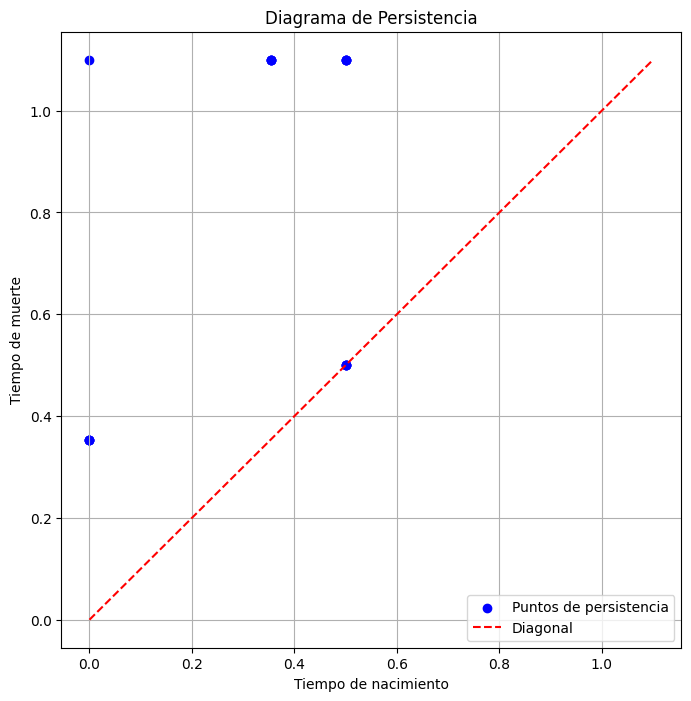

In [5]:
dibujar_diagrama_persistencia(diagrama)

*Interpretación: El diagrama de persistencia resume cómo las estructuras topológicas evolucionan con el aumento del parámetro 
𝛼
α en los alfa-complejos.

Las características más alejadas de la diagonal son las más relevantes topológicamente, ya que persisten durante una mayor parte de la filtración.
Las características cercanas a la diagonal son consideradas ruido o irrelevantes, ya que tienen una vida corta.*

Definir una función que dibuje los códigos de barras de una filtración de alfa complejos.

In [8]:
import matplotlib.pyplot as plt

def dibujar_codigo_barras(diagrama):
    """
    Dibuja los códigos de barras dados los puntos del diagrama de persistencia.

    Parámetros:
    - diagrama: lista de tuplas (nacimiento, muerte), donde cada tupla representa 
      un punto del diagrama de persistencia.
    """
    # Crear el gráfico
    plt.figure(figsize=(10, 6))
    
    # Iterar sobre el diagrama y agregar las barras
    for i, (nacimiento, muerte) in enumerate(diagrama):
        # Ajustar muerte infinito
        if muerte == float('inf'):
            muerte = max([m for _, m in diagrama if m != float('inf')], default=1) * 1.1
        # Dibujar una línea horizontal para cada característica
        plt.plot([nacimiento, muerte], [i, i], color="blue", lw=2)

    # Etiquetas del gráfico
    plt.title("Códigos de Barras de la Filtración")
    plt.xlabel("Tiempo de filtración (α)")
    plt.ylabel("Características topológicas")
    plt.yticks([])  # Eliminar el eje Y
    plt.grid(axis="x")
    plt.show()

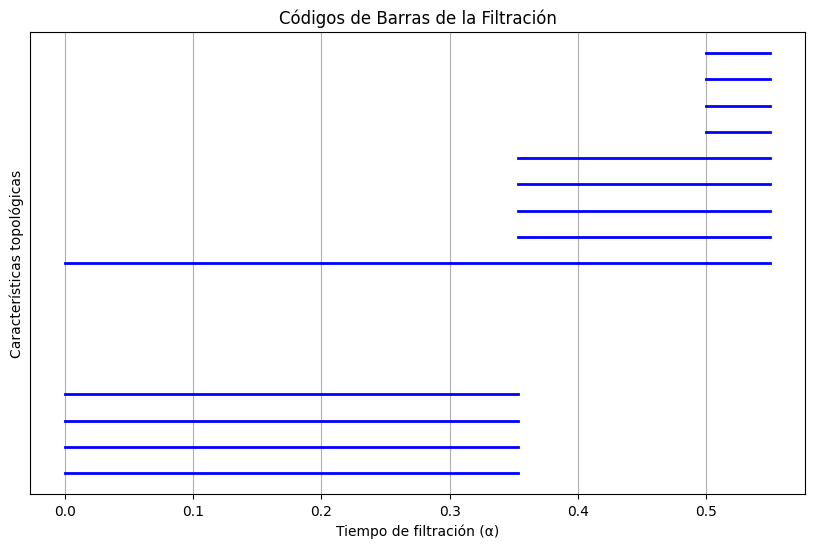

In [9]:
dibujar_codigo_barras(diagrama)

Probar las funciones con distintos conjuntos finitos de puntos en el plano que aproximen conjuntos conocidos (curvas como la circunferencia, la figura ocho, la elipse...)

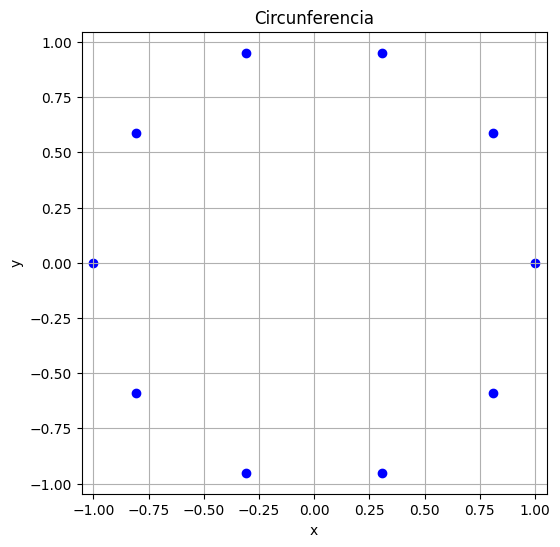

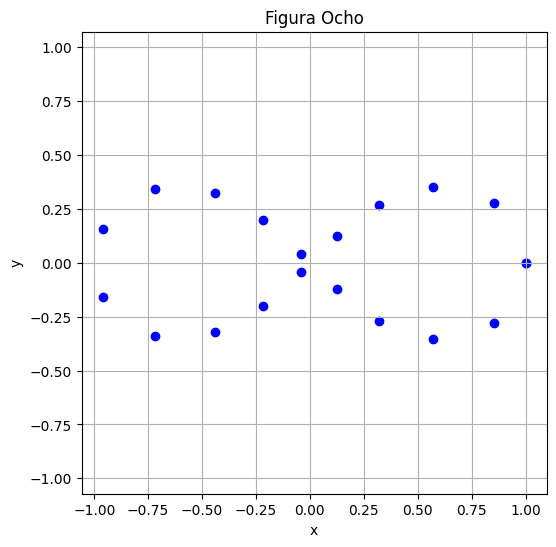

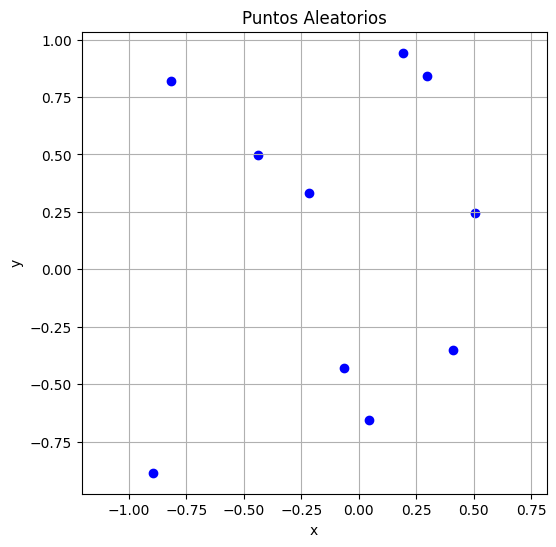

In [14]:
import numpy as np

# Circunferencia
def puntos_circunferencia(n_puntos=10, radio=1):
    """
    Genera un conjunto de puntos distribuidos uniformemente en una circunferencia.
    
    Parámetros:
    - n_puntos: Número de puntos a generar.
    - radio: Radio de la circunferencia.
    
    Retorna:
    - np.array con coordenadas (x, y) de los puntos.
    """
    angulos = np.linspace(0, 2 * np.pi, n_puntos, endpoint=False)
    puntos = np.array([(radio * np.cos(ang), radio * np.sin(ang)) for ang in angulos])
    return puntos

# Generar puntos para una circunferencia
puntos_circ = puntos_circunferencia(10)

# Figura ocho
def puntos_figura_ocho(n_puntos=20):
    """
    Genera un conjunto de puntos que forman una figura ocho (lemniscata de Bernoulli).
    
    Parámetros:
    - n_puntos: Número de puntos a generar.
    
    Retorna:
    - np.array con coordenadas (x, y) de los puntos.
    """
    t = np.linspace(0, 2 * np.pi, n_puntos)
    x = np.cos(t) / (1 + np.sin(t)**2)
    y = (np.sin(t) * np.cos(t)) / (1 + np.sin(t)**2)
    puntos = np.array([x, y]).T
    return puntos

# Generar puntos para una figura ocho
puntos_fig8 = puntos_figura_ocho(20)


# Puntos aleatorios en el plano
def puntos_aleatorios(n_puntos=10, rango=(-1, 1)):
    """
    Genera un conjunto aleatorio de puntos en el plano dentro de un rango dado.
    
    Parámetros:
    - n_puntos: Número de puntos a generar.
    - rango: Tuple (min, max) para las coordenadas x e y.
    
    Retorna:
    - np.array con coordenadas (x, y) de los puntos.
    """
    puntos = np.random.uniform(rango[0], rango[1], (n_puntos, 2))
    return puntos

# Generar puntos aleatorios
puntos_random = puntos_aleatorios(10)


import matplotlib.pyplot as plt

# Visualizar puntos
def graficar_puntos(puntos, titulo="Conjunto de Puntos"):
    plt.figure(figsize=(6, 6))
    plt.scatter(puntos[:, 0], puntos[:, 1], c="blue", marker="o")
    plt.title(titulo)
    plt.xlabel("x")
    plt.ylabel("y")
    plt.axis("equal")
    plt.grid()
    plt.show()

# Ejemplo de visualización
graficar_puntos(puntos_circ, "Circunferencia")
graficar_puntos(puntos_fig8, "Figura Ocho")
graficar_puntos(puntos_random, "Puntos Aleatorios")


Diagrama de Persistencia para Circunferencia


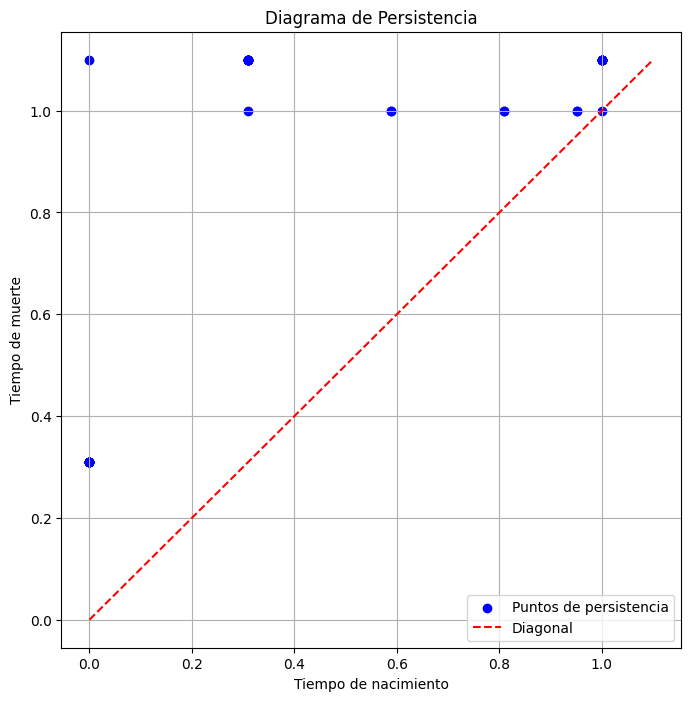

Códigos de Barras para Circunferencia


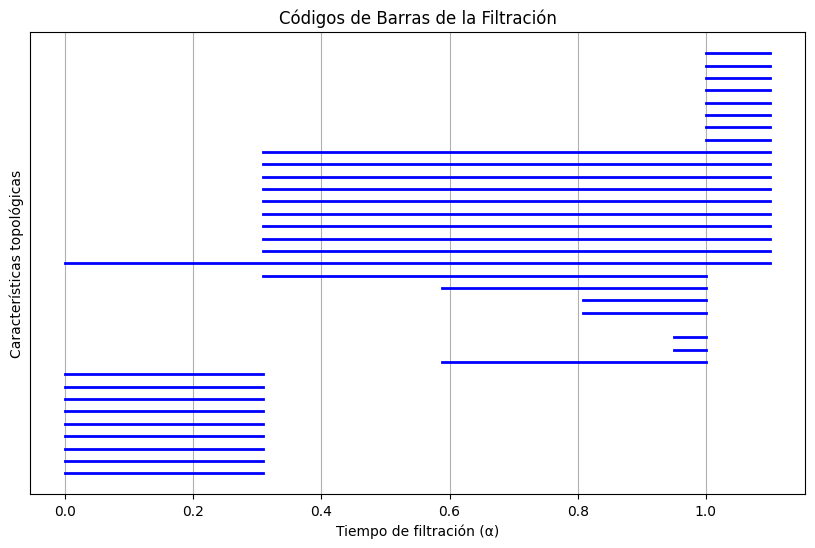

Diagrama de Persistencia para Figura Ocho


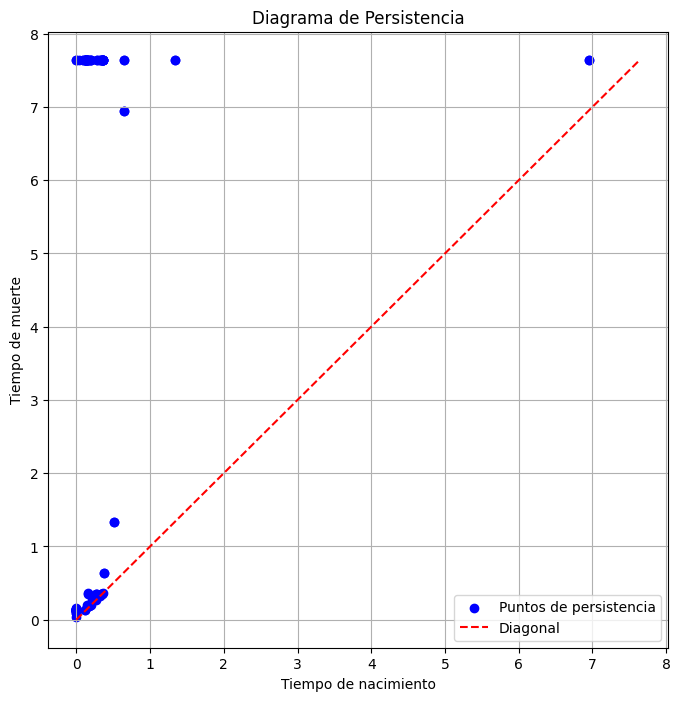

Códigos de Barras para Figura Ocho


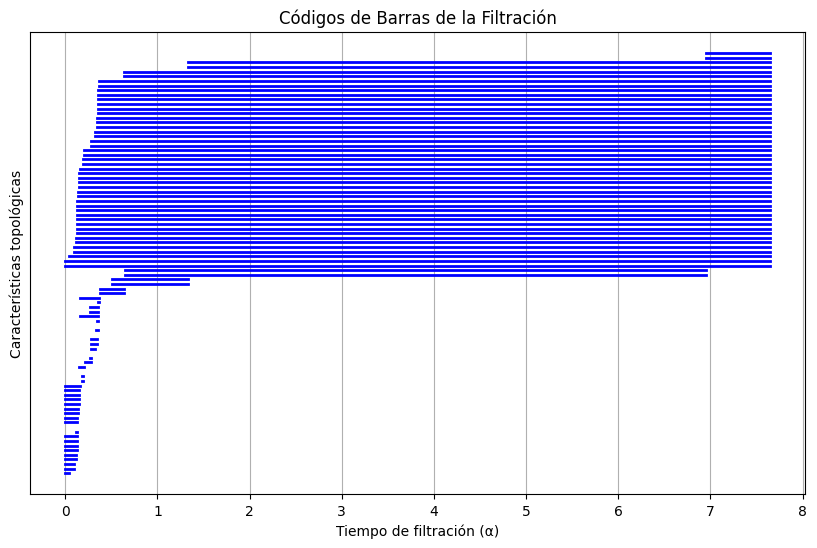

Diagrama de Persistencia para Puntos Aleatorios


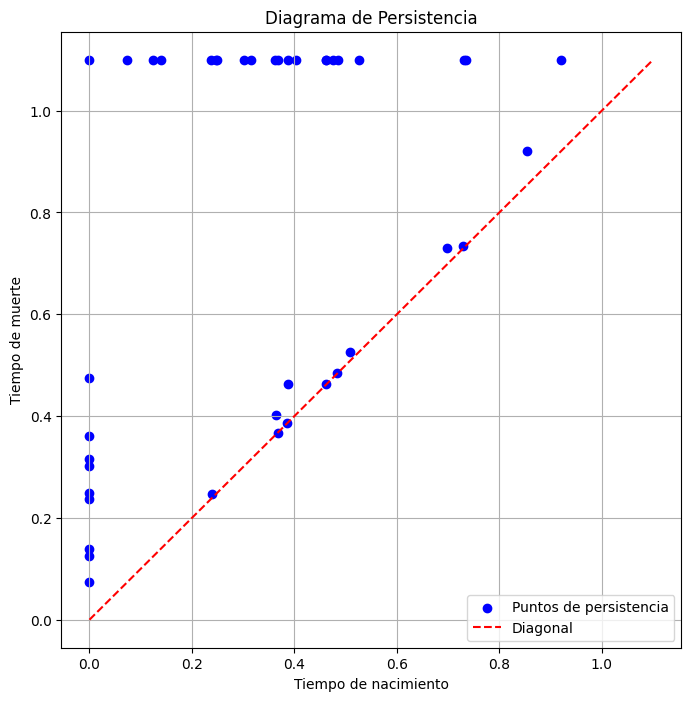

Códigos de Barras para Puntos Aleatorios


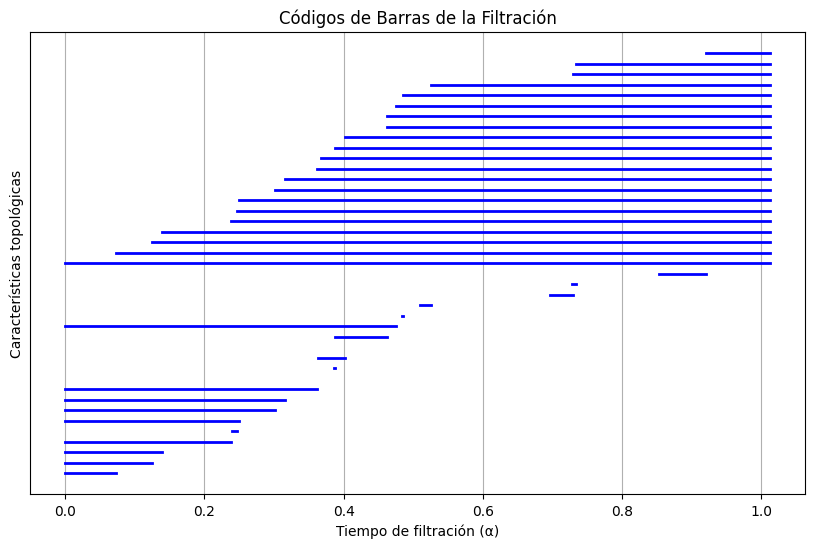

In [15]:
# Función para calcular y mostrar diagrama de persistencia y códigos de barras
def analizar_filtracion(puntos, nombre):
    """
    Calcula y muestra el diagrama de persistencia y códigos de barras para un conjunto de puntos.
    
    Parámetros:
    - puntos: np.array de puntos en el plano (x, y).
    - nombre: Nombre del conjunto de puntos (para los títulos).
    """
    
    # Calcular el diagrama de persistencia
    diagrama_persistencia = calcular_diagrama_persistencia(puntos)
    
    # Dibujar el diagrama de persistencia
    print(f"Diagrama de Persistencia para {nombre}")
    dibujar_diagrama_persistencia(diagrama_persistencia)
    
    # Dibujar el código de barras
    print(f"Códigos de Barras para {nombre}")
    dibujar_codigo_barras(diagrama_persistencia)

# Analizar los conjuntos de puntos
analizar_filtracion(puntos_circ, "Circunferencia")
analizar_filtracion(puntos_fig8, "Figura Ocho")
analizar_filtracion(puntos_random, "Puntos Aleatorios")